In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pickle
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels as sm
import os
import sqlite3
import gc
import xgboost
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def training_data():

    dir = '../../../SQL_Data/constant_setup'
    files = os.listdir(dir)
    files = [f for f in files if f.endswith('.sqlite3')]

    data = []
    for f in files:
        path = os.path.join(dir, f)
        conn = sqlite3.connect(path)
        if os.path.getsize(path) > 10000:
            cur = conn.cursor()
            cur.execute('SELECT * FROM walk_forward')
            df = pd.DataFrame(cur.fetchall())
            data.append(df)

    names = list(map(lambda x: x[0], cur.description))
    df = pd.concat(data)
    df.columns = names
    df = df.drop(['frameIdentifier','bestLapTime', 'pkt_id', 'packetId', 'SessionTime', 'lap_time_remaining'], axis=1)
    df.set_index('index', inplace=True)

    return df

def sub_sample(df):
    arr = []
    session_groups = df.groupby('sessionUID')
    for s in list(session_groups.groups):
        session = session_groups.get_group(s)
        lap_groups = session.groupby('currentLapNum')
        for l in list(lap_groups.groups):
            lap = lap_groups.get_group(l)
            df2 = lap[lap.index % 10 == 0]  # Selects every 10th row starting from 0
            arr.append(df2)

    sub_sampled_data = pd.concat(arr)
    print(f'Full sub sample shape {sub_sampled_data.shape}')
    return sub_sampled_data

def series_to_supervised(data,n_in=1, n_out=1, dropnan=True):
    n_vars = len(data.columns)
    df = data
    cols= [data]
    names = data.columns
    for i in range(n_in, 0, -1):
        neg_shift = df.shift(i)
        minus_names = [f'{name}_t-{i}' for name in names]
        neg_shift.columns = minus_names
        cols.append(neg_shift)

    if n_out > 1:
        for i in range(0, n_out):
            pos_shift = df.shift(-i)
            plus_names = [f'{name}_t+{i}' for name in names]
            pos_shift.columns = plus_names
            cols.append(pos_shift)

    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def build_model(trainX):
    print(f'Number of input dims: {trainX.shape[1]}')
    model = tf.keras.Sequential()
    model.add(Dense(64, input_dim=trainX.shape[1],  activation='relu', kernel_initializer='normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])

    print(model.summary())

    return model

def train_model(trainX, trainY, model):
    epochs=100
    callback = [EarlyStopping(monitor="loss", patience = 10, mode = 'auto', restore_best_weights=True),
                ModelCheckpoint('ann.h5')]
    history = model.fit(trainX, trainY, callbacks=callback, shuffle=False, epochs=epochs, batch_size=10)
    return model, history


def normalise_data(df):
    scalers = {}
    for col in list(df.columns):
        s = StandardScaler()
        df[col] = s.fit_transform(df[col].values.reshape(-1,1))
        scalers[col] = s
    print('Data Normalised')
    return df, scalers

def descale(df, scalers):
    for col in list(df.columns):
        df[col] = scalers[col].inverse_transform(df[col].values.reshape(-1,1))
    return df

def predictions(model, testX, testY, scalers):
    pred = model.predict(testX)
    testX = descale(testX, scalers)
    testX['finalLapTime'] = testY
    testX['predictions'] = pred.ravel()
    testX['residuals'] = testX['predictions'] - testX['finalLapTime']
    testX.rename({'finalLapTime':'truth'}, inplace=True)
    plt.scatter(testX['currentLapTime'], testX['residuals'], s=0.1)
    plt.show()
    return testX


In [4]:
    data = training_data()

    data = sub_sample(data)

    data.reset_index(drop=True, inplace=True)

    # data = pd.read_csv('../Bayesian_RNN/sample_data.csv')
    # data.drop(['index'], axis=1, inplace=True)

    df = series_to_supervised(data, n_in = 1, n_out=1, dropnan=True)

    df.drop(['finalLapTime_t-1', 'sessionUID_t-1'], axis=1, inplace=True)

    sessionUID = df.pop('sessionUID')

    labels = df.pop('finalLapTime')

    df, scalers = normalise_data(df)

    df['sessionUID'] = sessionUID


    trainX, testX, trainY, testY = train_test_split(df, labels, shuffle=True, test_size=0.2)

    trainX.drop(['sessionUID'], inplace=True, axis=1)


    testX = testX.sort_index()
    testY = testY.sort_index()

    test_sessions = testX.pop('sessionUID')

    # model = build_model(trainX)

    model = KerasRegressor(build_fn=build_model, trainX=trainX, nb_epoch=1)

    model.fit(trainX, trainY)

    perm = PermutationImportance(model, random_state=1).fit(trainX,trainY)



Full sub sample shape (177405, 49)
Data Normalised
Number of input dims: 94


/home/rufus/miniconda3/envs/tensorflow/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6080      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,465
Trainable params: 14,465
Non-trainable params: 0
_________________________________________________________________
None
4436/4436 [==============================] - 4s 868us/step - loss: 58.7070 - mae: 4.7291


4436/4436 [==============================] - 4s 871us/step - loss: 58.6481 - mae: 4.7615


4436/4436 [==============================] - 4s 874us/step - loss: 57.2121 - mae: 4.6587


4436/4436 [==============================] - 4s 884us/step - loss: 56.4045 - mae: 4.5777


4436/4436 [==============================] - 4s 965us/step - loss: 56.1877 - mae: 4.5545


4436/4436 [==============================] - 4s 905us/step - loss: 58.6732 - mae: 4.7908


In [11]:
weights = eli5.show_weights(perm)
imp = perm.feature_importances_

In [29]:
imp_df = pd.DataFrame()
imp_df['variable'] = trainX.columns
imp_df['importance'] = imp
imp_df.sort_values('importance', inplace=True, ascending=False)
display(imp_df)

,variable,importance
48,currentLapTime_t-1,45.119199
8,worldPositionZ,43.376108
55,worldPositionZ_t-1,37.514598
1,currentLapTime,36.522096
5,sector,21.123958
...,...,...
19,clutch,0.000000
91,rearWingDamage_t-1,0.000000
44,rearWingDamage,0.000000
66,clutch_t-1,0.000000


In [30]:
x = [x for x in range(len(imp_df['variable']))]
y = imp_df['importance'].tolist()
names = imp_df['variable'].tolist()


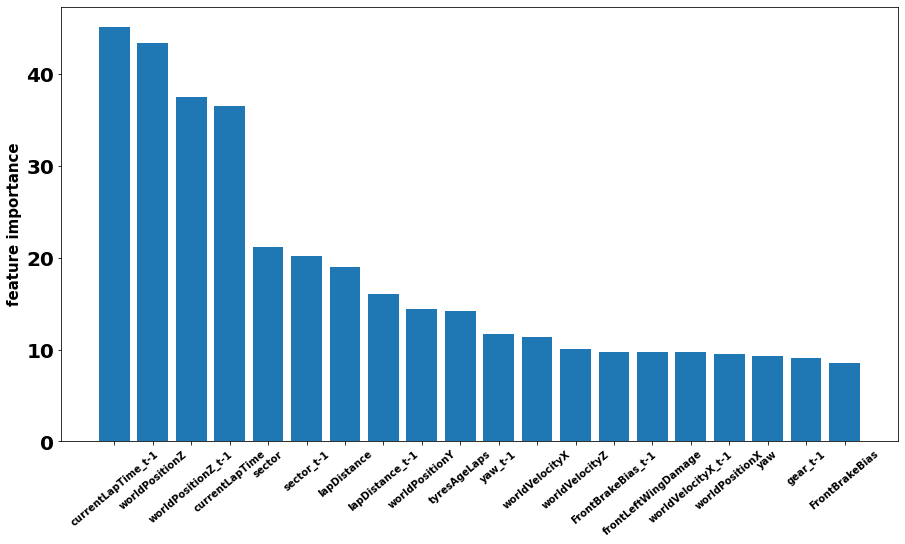

In [46]:
plt.figure(figsize=(15,8))
num_features = 20
x_ = x[:num_features]
y_ = y[:num_features]
names_ = names[:num_features]
plt.bar(x_,y_, tick_label=names_)
plt.xticks(rotation=40, fontsize=10, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.ylabel('feature importance', fontsize=15, fontweight='bold')
plt.savefig('ann_feature_importance.png')
plt.show()